# Interpretability Assignment

Language models are trained to predict tokens given other tokens. More specifically, the autoregressive Language Modelling objective is given by the following distribution:

$$
P(w_{t} \mid w_{t-1}, w_{t-2} \dots w_0)
$$

The standard Transformer-based Language Model sees tokens as the lowest granularity of language. It sees tokens as entities and predicts other tokens. These models are not given the spelling of a token explicitly.

The question we ask in this assignment is, "to what extent do the representations of words from an LM encode character information?"

"What is it about the Language Modelling objective that allows a model to deduce something about the characters of a token?"


To accomplish our purposes, we will conduct probing studies.
- design a task that relies on the spelling of a word.
- check if a thin (one layer) classifier can be trained on top of LM embeddings to do this task.
- design a control to check whether the task is too easy.

In [ ]:
import torch

## Initializing the model

We will be studying a pretrained RoBERTa model. Run the cell below to initialize it.

In [ ]:
# loading a small model

from transformers import AutoTokenizer, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base", config=config)
model.eval()
model.cuda()
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

## Example tokenization

Any input text given to the model is first toknized. Typically this is sub-word tokenization i.e. words are broken down further.

A sub subword is the most atomic input given to a language model. For example.

In [ ]:
sentence = "This is an example tokenization"
tokenizer.tokenize(sentence)

['This', 'Ġis', 'Ġan', 'Ġexample', 'Ġtoken', 'ization']

As can be seen above, the word "tokenzation" has been broken down into "token" and "ization"

There is no explicit granulairity more than this. In other words, the model __does not directly__ see letters of a word.

The Language Model is trained to predict the next token given the previous tokens. Should this give it a sense of what letters exist in that token?

## Experiment 1

Can the model do something simple like distinguish between capitalized and non-capitalized words?

In other words, we ask if there is a reliable signal in the representations from the model for us to be able to predict whether a word is capitalized or not.

### Q1.1 Make appropriate dataset

In [ ]:
!git clone https://github.com/dwyl/english-words.git

Cloning into 'english-words'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 248 (delta 97), reused 83 (delta 83), pack-reused 123
Receiving objects: 100% (248/248), 27.63 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [ ]:
words_list = []
with open("english-words/words_alpha.txt") as f:
    for line in f:
        words_list.append(line.strip())

Take the word list and phrase a classification problem to check the above sub-task:

- Make a train set
- Make a validation set
- Make a test set

In [ ]:
word_list_small = [word.lower() for word in words_list]
dataset = []

label = 0
import random
for i, word in enumerate(word_list_small):
    if random.random() > 0.5:
        label = 1
        word = word.capitalize()
    else:
        label = 0
    dataset.append((word, label,))

In [ ]:
from sklearn.model_selection import train_test_split
# split into three
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
def check_train_val_test_splits(train, val, test):
    assert len(train) > 0
    assert len(val) > 0
    assert len(test) > 0
    train_set = set(train)
    val_set = set(val)
    test_set = set(test)
    assert len(train_set.intersection(val_set)) == 0
    assert len(train_set.intersection(test_set)) == 0
    assert len(val_set.intersection(test_set)) == 0
    print("All checks passed")


# pass your datasets here
check_train_val_test_splits(train, val, test)

All checks passed


In [ ]:
DEVICE = "cuda"

### Get the embeddings from the model for those words

In [ ]:
def get_embeddings_all_layers(model, tokenizer, data, pool_func, layer=-1,):
    embed_list = []
    for word, label in data:
        # print(word)
        inputs = tokenizer(word, return_tensors="pt").to(device=DEVICE)
        # print(inputs)
        embeddings = model(**inputs, output_hidden_states=True)
        # embeddings = torch.stack(outputs.hidden_states).squeeze()
        # print(len(embeddings.hidden_states))
        embeddings = embeddings.hidden_states[layer].detach().cpu().numpy()
        embeddings = pool_func(embeddings, dim=-2)
        embed_list.append(embeddings)
    return embed_list

In [ ]:
import torch
import numpy as np

check_data = [("warul", "student")]
get_embeddings_all_layers(model, tokenizer, check_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
print("Checked")

Checked


In [ ]:
# randomly chose 50% of the train data
train_small = random.sample(train, int(len(train) * 0.005))
test_small = random.sample(test, int(len(train) * 0.005))


embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)


assert embeds[0].shape[-1] == config.hidden_size


In [ ]:
# concatenate the embeddings
print(len(embeds))
mx = 0
for i in range(1184):
  mx = max(mx, len(embeds[i]))
print(mx)
print(len(embeds[0][0]))

1184
1
768


In [ ]:
embeds = np.concatenate(embeds, axis=0)
embeds_test = np.concatenate(embeds_test, axis=0)

In [ ]:
embeds

array([[ 0.01795859,  0.04817585,  0.16921423, ..., -0.02041177,
         0.02306178,  0.02147947],
       [ 0.00236014,  0.10202327,  0.06134211, ..., -0.12696858,
        -0.00063394, -0.01768548],
       [-0.012165  ,  0.02392032,  0.06186189, ..., -0.05552826,
         0.01242237, -0.02023846],
       ...,
       [-0.01271607,  0.18692024, -0.01790146, ..., -0.04053653,
        -0.11456251, -0.01451407],
       [-0.06040657,  0.00056395,  0.03959761, ..., -0.00684818,
         0.05830708,  0.10657257],
       [-0.03056503,  0.07005043,  0.05705455, ...,  0.01839833,
        -0.0852409 , -0.00707278]], dtype=float32)

In [ ]:
embeds.shape

(1184, 768)

In [ ]:
embeds_test.shape

(1184, 768)

### Make a classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_regress = LogisticRegression(max_iter=1000)
log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       585
           1       1.00      0.99      0.99       599

    accuracy                           0.99      1184
   macro avg       0.99      0.99      0.99      1184
weighted avg       0.99      0.99      0.99      1184



## Extracting specific letter information from encodings

Check if the model embeddings encode information about the _first_ letter of a word.

Code up the experiment for this

- Make a balanced dataset __[4]__
- Train a classifier __[2]__
- Print a  classification report (precision and recall for all classes) __[2]__


In [ ]:
words_set = set(word_list_small)
print(words_list == word_list_small)

True


In [ ]:
print(len(words_set), len(set(words_list)))

370105 370105


In [ ]:
words_of_interest = []
any_freq_by_first_char = {}
for word in words_list:
  words_of_interest.append(word)
  first_char = word[0]
  prev_freq = any_freq_by_first_char.get(first_char, 0)
  any_freq_by_first_char[first_char] = 1 + prev_freq

word_count = len(words_of_interest)
print(word_count)
print(any_freq_by_first_char)
print(f"{max(any_freq_by_first_char.values())}, {min(any_freq_by_first_char.values())}")

370105
{'a': 25417, 'b': 18413, 'c': 32107, 'd': 18733, 'e': 14197, 'f': 11893, 'g': 10953, 'h': 13743, 'i': 13199, 'y': 1143, 'j': 2840, 'k': 3952, 'l': 10002, 'm': 19805, 'n': 13459, 'o': 12681, 'p': 34860, 'q': 1793, 'r': 16783, 's': 38764, 't': 18819, 'u': 22767, 'v': 5329, 'w': 6559, 'x': 507, 'z': 1387}
38764, 507


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

SELECTION_COUNT = 20 # selecting 20 words with each different starting character

any_balanced_inputs = []
for word in words_list:
  first_char = word[0]
  selection_probability = SELECTION_COUNT / any_freq_by_first_char[first_char]
  if random.random() < selection_probability:
    any_balanced_inputs.append(word)

# print(len(any_balanced_inputs))
any_freq_by_label = {}
for word in any_balanced_inputs:
  label = word[0]
  prev_freq = any_freq_by_label.get(label, 0)
  any_freq_by_label[label] = 1 + prev_freq
# print(any_freq_by_label)

any_train_inputs = []
any_train_labels = []
any_test_inputs = []
any_test_labels = []
for word in any_balanced_inputs:
  if random.random() < 0.8:
    any_train_inputs.append(word)
    any_train_labels.append(word[0])
  else:
    any_test_inputs.append(word)
    any_test_labels.append(word[0])

any_train_data = [(any_train_inputs[i], any_train_labels[i]) for i in range(len(any_train_inputs))]
any_test_data = [(any_test_inputs[i], any_test_labels[i]) for i in range(len(any_test_inputs))]

any_embeds_all = get_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
any_embeds_all_test = get_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)

any_embeds_all = np.concatenate(any_embeds_all, axis=0)
any_embeds_all_test = np.concatenate(any_embeds_all_test, axis=0)

any_rfc_all = RandomForestClassifier(random_state=0)
any_rfc_all.fit(any_embeds_all, any_train_labels)

print(classification_report(any_test_labels, any_rfc_all.predict(any_embeds_all_test)))

              precision    recall  f1-score   support

           a       0.00      0.00      0.00         6
           b       0.12      0.33      0.18         3
           c       0.00      0.00      0.00         4
           d       0.17      0.14      0.15         7
           e       0.07      0.33      0.12         3
           f       0.50      0.50      0.50         6
           g       0.30      0.43      0.35         7
           h       0.43      0.38      0.40         8
           i       0.00      0.00      0.00         1
           j       0.33      0.17      0.22         6
           k       0.00      0.00      0.00         4
           l       0.00      0.00      0.00         4
           m       0.25      0.17      0.20         6
           n       0.00      0.00      0.00         3
           o       0.00      0.00      0.00         2
           p       0.50      0.11      0.18         9
           q       0.67      0.33      0.44         6
           r       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

SELECTION_COUNT = 200 # selecting 200 words with each different starting character

any_balanced_inputs = []
for word in words_list:
  first_char = word[0]
  selection_probability = SELECTION_COUNT / any_freq_by_first_char[first_char]
  if random.random() < selection_probability:
    any_balanced_inputs.append(word)

# print(len(any_balanced_inputs))
any_freq_by_label = {}
for word in any_balanced_inputs:
  label = word[0]
  prev_freq = any_freq_by_label.get(label, 0)
  any_freq_by_label[label] = 1 + prev_freq
# print(any_freq_by_label)

any_train_inputs = []
any_train_labels = []
any_test_inputs = []
any_test_labels = []
for word in any_balanced_inputs:
  if random.random() < 0.8:
    any_train_inputs.append(word)
    any_train_labels.append(word[0])
  else:
    any_test_inputs.append(word)
    any_test_labels.append(word[0])

any_train_data = [(any_train_inputs[i], any_train_labels[i]) for i in range(len(any_train_inputs))]
any_test_data = [(any_test_inputs[i], any_test_labels[i]) for i in range(len(any_test_inputs))]

any_embeds_all = get_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
any_embeds_all_test = get_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)

any_embeds_all = np.concatenate(any_embeds_all, axis=0)
any_embeds_all_test = np.concatenate(any_embeds_all_test, axis=0)

any_rfc_all = RandomForestClassifier(random_state=0)
any_rfc_all.fit(any_embeds_all, any_train_labels)

print(classification_report(any_test_labels, any_rfc_all.predict(any_embeds_all_test)))

              precision    recall  f1-score   support

           a       0.11      0.12      0.11        34
           b       0.21      0.45      0.29        31
           c       0.18      0.15      0.16        34
           d       0.43      0.46      0.44        35
           e       0.30      0.17      0.22        42
           f       0.32      0.33      0.33        33
           g       0.25      0.30      0.27        43
           h       0.25      0.33      0.29        39
           i       0.20      0.34      0.26        35
           j       0.33      0.55      0.41        31
           k       0.72      0.57      0.64        40
           l       0.37      0.49      0.42        35
           m       0.19      0.07      0.10        45
           n       0.57      0.40      0.47        43
           o       0.57      0.26      0.35        47
           p       0.21      0.22      0.21        27
           q       0.64      0.61      0.63        44
           r       0.27    

## We see significant improvements on increasing the size of the dataset.
## Going forward we enforce the property that only words whose first token is not a word in words_list will be considered.
- On the obtained dataset, we will do a study to see whether models learn semantics or spellings.
- Since, the above property is sparse, the dataset size shall be limited, which would understandably impact performance. Through the study, our goal is to find relative performance

# Task1: Conclusion
The model has some notion of the first letter of the word as it outperforms the random case (1/26) by an over an order of magnitude for the given dataset. Although the performance is better than random, it is not exceptional, and considering the small size of the dataset, this is within expectations.

## Do we need 'real' words?

Devise an experiment to check if the model is using semantic information to make its predictions (and not some direct notion of spelling)

- Design an experiment to make it impossible for the semantics to be used in the above task. __[4]__
- Make a dataset for it __[2]__
- Learn a classifier for it __[1]__
- Do the analysis across layers __[3]__

### Idea - Only consider the first token of the word to see whether the model can still predict as well as before.

In [ ]:
words_of_interest = []
freq_by_first_char = {}
for word in words_list:
  tokens = tokenizer.tokenize(word)
  if tokens[0] in words_set:
    continue

  words_of_interest.append(word)
  first_char = word[0]
  prev_freq = freq_by_first_char.get(first_char, 0)
  freq_by_first_char[first_char] = 1 + prev_freq

word_count = len(words_of_interest)
print(word_count)
print(freq_by_first_char)
print(f"{max(freq_by_first_char.values())}, {min(freq_by_first_char.values())}")

30297
{'a': 3784, 'b': 651, 'c': 1805, 'd': 353, 'e': 2834, 'f': 463, 'g': 843, 'h': 909, 'i': 1625, 'y': 26, 'j': 200, 'k': 431, 'l': 237, 'm': 502, 'n': 462, 'o': 1731, 'p': 3592, 'q': 39, 'r': 1023, 's': 2553, 't': 1516, 'u': 3257, 'v': 951, 'w': 217, 'x': 19, 'z': 274}
3784, 19


In [ ]:
SELECTION_COUNT = 20 # selecting 20 words with each different starting character

balanced_inputs = []
for word in words_of_interest:
  first_char = word[0]
  selection_probability = SELECTION_COUNT / freq_by_first_char[first_char]
  if random.random() < selection_probability:
    balanced_inputs.append(word)

In [ ]:
print(len(balanced_inputs))
freq_by_label = {}
for word in balanced_inputs:
  label = word[0]
  prev_freq = freq_by_label.get(label, 0)
  freq_by_label[label] = 1 + prev_freq
print(freq_by_label)

531
{'a': 31, 'b': 25, 'c': 20, 'd': 28, 'e': 21, 'f': 23, 'g': 19, 'h': 16, 'y': 19, 'i': 23, 'j': 19, 'k': 23, 'l': 22, 'm': 23, 'n': 23, 'o': 18, 'p': 17, 'q': 20, 'r': 11, 's': 15, 't': 22, 'u': 19, 'v': 13, 'w': 29, 'x': 19, 'z': 13}


In [ ]:
total_tokens = 0
single_tokened = 0
token_is_word = 0
for word in balanced_inputs:
  tokens = tokenizer.tokenize(word)
  total_tokens += len(tokens)
  if len(tokens) == 1:
    single_tokened += 1
  for token in tokens:
    if token in words_set:
      token_is_word += 1

print(f"Total tokens: {total_tokens}, Average no. of tokens: {total_tokens / len(balanced_inputs)}")
print(f"Single tokened: {single_tokened}, Token is word: {token_is_word}")

Total tokens: 1525, Average no. of tokens: 2.871939736346516
Single tokened: 0, Token is word: 650


In [ ]:
train_inputs = []
train_labels = []
test_inputs = []
test_labels = []
for word in balanced_inputs:
  if random.random() < 0.8:
    train_inputs.append(word)
    train_labels.append(word[0])
  else:
    test_inputs.append(word)
    test_labels.append(word[0])

In [ ]:
print(len(train_inputs), len(test_inputs))

430 101


In [ ]:
train_data = [(train_inputs[i], train_labels[i]) for i in range(len(train_inputs))]
test_data = [(test_inputs[i], test_labels[i]) for i in range(len(test_inputs))]

In [ ]:
embeds_all = get_embeddings_all_layers(model, tokenizer, train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_all_test = get_embeddings_all_layers(model, tokenizer, test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_all = np.concatenate(embeds_all, axis=0)
embeds_all_test = np.concatenate(embeds_all_test, axis=0)
# print(embeds_all.shape)
# print(embeds_all_test.shape)
rfc_all = RandomForestClassifier(random_state=0)
rfc_all.fit(embeds_all, train_labels)
print(classification_report(test_labels, rfc_all.predict(embeds_all_test)))

              precision    recall  f1-score   support

           a       0.11      0.33      0.16         6
           b       0.20      0.12      0.15         8
           c       0.00      0.00      0.00         3
           d       0.11      1.00      0.19         2
           e       0.00      0.00      0.00         4
           f       0.50      0.17      0.25         6
           g       0.00      0.00      0.00         5
           h       0.00      0.00      0.00         1
           i       0.00      0.00      0.00         6
           j       0.50      0.67      0.57         3
           k       0.50      0.67      0.57         3
           l       0.00      0.00      0.00         1
           m       0.25      0.25      0.25         4
           n       0.20      0.12      0.15         8
           o       0.00      0.00      0.00         1
           p       0.33      0.25      0.29         4
           q       0.25      0.25      0.25         4
           r       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def get_first_token_embeddings_all_layers(model, tokenizer, data, pool_func, layer=-1):
    embed_list = []
    for word, label in data:
        inputs = tokenizer(tokenizer.tokenize(word)[0], return_tensors="pt").to(device=DEVICE)
        embeddings = model(**inputs, output_hidden_states=True)
        embeddings = embeddings.hidden_states[layer].detach().cpu().numpy()
        embeddings = pool_func(embeddings, dim=-2)
        embed_list.append(embeddings)
    return embed_list

In [ ]:
embeds_first = get_first_token_embeddings_all_layers(model, tokenizer, train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_first_test = get_first_token_embeddings_all_layers(model, tokenizer, test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_first = np.concatenate(embeds_first, axis=0)
embeds_first_test = np.concatenate(embeds_first_test, axis=0)
rfc_first = RandomForestClassifier(random_state=0)
rfc_first.fit(embeds_first, train_labels)
print(classification_report(test_labels, rfc_first.predict(embeds_all_test)))

              precision    recall  f1-score   support

           a       0.00      0.00      0.00         6
           b       0.00      0.00      0.00         8
           c       0.00      0.00      0.00         3
           d       0.00      0.00      0.00         2
           e       0.00      0.00      0.00         4
           f       0.00      0.00      0.00         6
           g       0.00      0.00      0.00         5
           h       0.00      0.00      0.00         1
           i       0.00      0.00      0.00         6
           j       0.00      0.00      0.00         3
           k       0.00      0.00      0.00         3
           l       0.00      0.00      0.00         1
           m       0.00      0.00      0.00         4
           n       0.00      0.00      0.00         8
           o       0.00      0.00      0.00         1
           p       0.00      0.00      0.00         4
           q       0.00      0.00      0.00         4
           r       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Layer wise analysis

In [ ]:
# Already checked results for last layer
for layer in range(12):
  embeds_all = get_embeddings_all_layers(model, tokenizer, train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)
  embeds_all_test = get_embeddings_all_layers(model, tokenizer, test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)
  embeds_all = np.concatenate(embeds_all, axis=0)
  embeds_all_test = np.concatenate(embeds_all_test, axis=0)
  # print(embeds_all.shape)
  # print(embeds_all_test.shape)
  rfc_all = RandomForestClassifier(random_state=0)
  rfc_all.fit(embeds_all, train_labels)
  print(f"Layer: {layer}")
  print(classification_report(test_labels, rfc_all.predict(embeds_all_test)))
  print("\n")

Layer: 0
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.43      0.75      0.55         4
           c       0.00      0.00      0.00         1
           d       0.25      0.75      0.38         4
           e       0.00      0.00      0.00         5
           f       0.67      0.50      0.57         4
           g       0.22      1.00      0.36         2
           h       0.22      1.00      0.36         2
           i       0.00      0.00      0.00         3
           j       0.64      1.00      0.78         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.40      1.00      0.57         2
           n       0.67      0.29      0.40         7
           o       0.00      0.00      0.00        11
           p       1.00      0.11      0.20         9
           q       0.56      1.00      0.71         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 2
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.67      0.50      0.57         4
           c       0.00      0.00      0.00         1
           d       0.18      0.50      0.27         4
           e       0.00      0.00      0.00         5
           f       0.67      0.50      0.57         4
           g       0.15      1.00      0.27         2
           h       0.25      1.00      0.40         2
           i       0.09      0.33      0.14         3
           j       0.70      1.00      0.82         7
           k       0.25      0.50      0.33         2
           l       0.00      0.00      0.00         3
           m       1.00      1.00      1.00         2
           n       0.50      0.14      0.22         7
           o       0.33      0.09      0.14        11
           p       1.00      0.11      0.20         9
           q       0.83      1.00      0.91         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 7
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.18      0.50      0.27         4
           e       0.00      0.00      0.00         5
           f       1.00      0.25      0.40         4
           g       0.11      0.50      0.18         2
           h       0.17      1.00      0.29         2
           i       0.00      0.00      0.00         3
           j       0.40      0.86      0.55         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       1.00      0.50      0.67         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.33      0.11      0.17         9
           q       0.25      0.40      0.31         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 8
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       1.00      0.25      0.40         4
           c       0.00      0.00      0.00         1
           d       0.18      0.50      0.27         4
           e       0.33      0.20      0.25         5
           f       1.00      0.50      0.67         4
           g       0.25      1.00      0.40         2
           h       0.06      0.50      0.10         2
           i       0.00      0.00      0.00         3
           j       0.55      0.86      0.67         7
           k       0.20      0.50      0.29         2
           l       0.00      0.00      0.00         3
           m       0.67      1.00      0.80         2
           n       0.00      0.00      0.00         7
           o       0.50      0.18      0.27        11
           p       0.50      0.11      0.18         9
           q       0.30      0.60      0.40         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 9
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.15      0.50      0.24         4
           e       0.00      0.00      0.00         5
           f       0.33      0.25      0.29         4
           g       0.17      0.50      0.25         2
           h       0.08      1.00      0.15         2
           i       0.14      0.33      0.20         3
           j       0.50      0.86      0.63         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.17      0.50      0.25         2
           n       0.00      0.00      0.00         7
           o       1.00      0.09      0.17        11
           p       0.00      0.00      0.00         9
           q       0.40      0.40      0.40         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 10
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.18      0.50      0.27         4
           e       0.00      0.00      0.00         5
           f       1.00      0.50      0.67         4
           g       0.17      0.50      0.25         2
           h       0.08      0.50      0.13         2
           i       0.00      0.00      0.00         3
           j       0.75      0.86      0.80         7
           k       0.17      0.50      0.25         2
           l       0.00      0.00      0.00         3
           m       0.14      0.50      0.22         2
           n       0.20      0.14      0.17         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.50      0.80      0.62         5
           r     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 11
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.23      0.75      0.35         4
           e       0.50      0.20      0.29         5
           f       1.00      0.50      0.67         4
           g       0.14      1.00      0.25         2
           h       0.07      0.50      0.12         2
           i       0.00      0.00      0.00         3
           j       0.55      0.86      0.67         7
           k       0.17      0.50      0.25         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       1.00      0.09      0.17        11
           p       1.00      0.11      0.20         9
           q       0.50      0.20      0.29         5
           r     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Already checked results for last layer
for layer in range(12):
  embeds_first = get_first_token_embeddings_all_layers(model, tokenizer, train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
  embeds_first_test = get_first_token_embeddings_all_layers(model, tokenizer, test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
  embeds_first = np.concatenate(embeds_first, axis=0)
  embeds_first_test = np.concatenate(embeds_first_test, axis=0)
  rfc_first = RandomForestClassifier(random_state=0)
  rfc_first.fit(embeds_first, train_labels)
  print(f"Layer: {layer}")
  print(classification_report(test_labels, rfc_first.predict(embeds_all_test)))
  print("\n")

Layer: 0
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 1
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 2
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 3
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 4
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 5
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 6
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 7
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 8
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 9
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 10
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 11
              precision    recall  f1-score   support

           a       0.00      0.00      0.00         1
           b       0.00      0.00      0.00         4
           c       0.00      0.00      0.00         1
           d       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         5
           f       0.00      0.00      0.00         4
           g       0.00      0.00      0.00         2
           h       0.00      0.00      0.00         2
           i       0.00      0.00      0.00         3
           j       0.06      0.57      0.11         7
           k       0.00      0.00      0.00         2
           l       0.00      0.00      0.00         3
           m       0.00      0.00      0.00         2
           n       0.00      0.00      0.00         7
           o       0.00      0.00      0.00        11
           p       0.00      0.00      0.00         9
           q       0.00      0.00      0.00         5
           r     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Task 2 - Conclusion
- We see a significant drop in the model's performance when limiting it to only observe the first token of a word, since our property ensures that the token does not match any word in the dictionary, there are no semantics attached, and we find that the drop in performance relative to earler implies that the model did indeed learn semantics.
- It also shows that doing so makes it impossible for the model to learn semantics. Another way to do it would be to shuffle tokens after the first one, which would break semantics, denying the model a chance to learn semantics.
- When analyzing performance over layers, for the semantic experiment (where all tokens in a word are given to the model), the weighted average of accuracy lies between 0.3 - 0.6, across layers, which is at least an order of magnitude better than random. We hypothesize that considering layers together might possibly yield more information.
- When analyzing performance over layers, for the non-semantic experiment (where only the first token of the word is given to the model), the weighted average of accuracy is consistently 0.01, across layers, which agrees with our findings that the model does not learn spellings.

# Custom Section

## Make a Hypothesis [5]

Based on the experiments from the previous section, come up with an intuition of how doing Language Modelling could teach the model about those aspects of spelling?

## Design an experiment [5]

Design your own probing experiment to check for an interesting subtask using spelling.

## Code up using the guidelines from the previous cells [8]

## Do layer-wise analysis on your task [4]

Do probes for particular layers do better than others?

Make a layer-wise plot


## Bonus: Design a control task for your experiment [10]

Reference: https://arxiv.org/abs/1909.03368




Hypothesis: To teach the model about capturing the first letter in a word, we first need to understand first that the model does not see words, but instead, tokens, and the concept of the first letter of a word is lost after breaking into tokens, as only few tokens capture this information, and which ones do is also unknown to the model. One way to go around this is to consider words as a singular unit - given the higher performance over the original unmodified dataset, we believe that such a training should help the model capture first-character/spelling information

Task - estimate length of a word

In [ ]:
def get_shuffled_embeddings_all_layers(model, tokenizer, data, pool_func, layer=-1,):
    embed_list = []
    for word, label in data:
        # print(word)
        tokens = tokenizer.tokenize(word)
        random.shuffle(tokens)
        shuffled_word = "".join(tokens)
        inputs = tokenizer(shuffled_word, return_tensors="pt").to(device=DEVICE)
        # print(inputs)
        embeddings = model(**inputs, output_hidden_states=True)
        # embeddings = torch.stack(outputs.hidden_states).squeeze()
        # print(len(embeddings.hidden_states))
        embeddings = embeddings.hidden_states[layer].detach().cpu().numpy()
        embeddings = pool_func(embeddings, dim=-2)
        embed_list.append(embeddings)
    return embed_list

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

SELECTION_COUNT = 50 # selecting 50 words with each different starting character

any_balanced_inputs = []
for word in words_list:
  first_char = word[0]
  selection_probability = SELECTION_COUNT / any_freq_by_first_char[first_char]
  if random.random() < selection_probability:
    any_balanced_inputs.append(word)

# print(len(any_balanced_inputs))
any_freq_by_label = {}
for word in any_balanced_inputs:
  label = word[0]
  prev_freq = any_freq_by_label.get(label, 0)
  any_freq_by_label[label] = 1 + prev_freq
# print(any_freq_by_label)

any_train_inputs = []
any_train_labels = []
any_test_inputs = []
any_test_labels = []
for word in any_balanced_inputs:
  if random.random() < 0.8:
    any_train_inputs.append(word)
    any_train_labels.append(len(word))
  else:
    any_test_inputs.append(word)
    any_test_labels.append(len(word))

any_train_data = [(any_train_inputs[i], any_train_labels[i]) for i in range(len(any_train_inputs))]
any_test_data = [(any_test_inputs[i], any_test_labels[i]) for i in range(len(any_test_inputs))]

any_embeds = get_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
any_embeds_test = get_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)

any_embeds = np.concatenate(any_embeds, axis=0)
any_embeds_test = np.concatenate(any_embeds_test, axis=0)

any_lr = LinearRegression()
any_lr.fit(any_embeds, any_train_labels)

mae = mean_absolute_error(any_test_labels, any_lr.predict(any_embeds_test))
print(f"MAE: {mae}")
average_test_len = sum(any_test_labels) / len(any_test_labels)
print(f"Average Test Length: {average_test_len}, Percentage error: {mae/average_test_len * 100.0}")

MAE: 1.9187750658713096
Average Test Length: 9.173553719008265, Percentage error: 20.916376844182743


### Shuffling Tokens

In [ ]:
any_embeds = get_shuffled_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
any_embeds_test = get_shuffled_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)

any_embeds = np.concatenate(any_embeds, axis=0)
any_embeds_test = np.concatenate(any_embeds_test, axis=0)

any_lr = LinearRegression()
any_lr.fit(any_embeds, any_train_labels)

mae = mean_absolute_error(any_test_labels, any_lr.predict(any_embeds_test))
print(f"MAE: {mae}")
average_test_len = sum(any_test_labels) / len(any_test_labels)
print(f"Average Test Length: {average_test_len}, Percentage error: {mae/average_test_len * 100.0}")

MAE: 1.9189130294421488
Average Test Length: 9.173553719008265, Percentage error: 20.917880771396398


In [ ]:
maes_normal = []
for layer in range(13):
  any_embeds = get_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)
  any_embeds_test = get_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)

  any_embeds = np.concatenate(any_embeds, axis=0)
  any_embeds_test = np.concatenate(any_embeds_test, axis=0)

  any_lr = LinearRegression()
  any_lr.fit(any_embeds, any_train_labels)

  mae = mean_absolute_error(any_test_labels, any_lr.predict(any_embeds_test))
  maes_normal.append(mae)
  print(f"Layer: {layer}, MAE: {mae}")
  average_test_len = sum(any_test_labels) / len(any_test_labels)
  print(f"Average Test Length: {average_test_len}, Percentage error: {mae/average_test_len * 100.0}")
  print()

Layer: 0, MAE: 1.094960271819564
Average Test Length: 9.173553719008265, Percentage error: 11.936053413528578

Layer: 1, MAE: 1.1826736828512396
Average Test Length: 9.173553719008265, Percentage error: 12.892208614864863

Layer: 2, MAE: 1.354443762913223
Average Test Length: 9.173553719008265, Percentage error: 14.76465723536036

Layer: 3, MAE: 1.2923896726497934
Average Test Length: 9.173553719008265, Percentage error: 14.088211746903154

Layer: 4, MAE: 1.323710291838843
Average Test Length: 9.173553719008265, Percentage error: 14.429634712837839

Layer: 5, MAE: 1.4101512057722108
Average Test Length: 9.173553719008265, Percentage error: 15.371918549408784

Layer: 6, MAE: 1.4192802492252066
Average Test Length: 9.173553719008265, Percentage error: 15.47143334740991

Layer: 7, MAE: 1.4161059166774277
Average Test Length: 9.173553719008265, Percentage error: 15.436830262880067

Layer: 8, MAE: 1.5650039546745869
Average Test Length: 9.173553719008265, Percentage error: 17.05995301942567

In [ ]:
maes_shuffled = []
for layer in range(13):
  any_embeds = get_shuffled_embeddings_all_layers(model, tokenizer, any_train_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)
  any_embeds_test = get_shuffled_embeddings_all_layers(model, tokenizer, any_test_data, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer)

  any_embeds = np.concatenate(any_embeds, axis=0)
  any_embeds_test = np.concatenate(any_embeds_test, axis=0)

  any_lr = LinearRegression()
  any_lr.fit(any_embeds, any_train_labels)

  mae = mean_absolute_error(any_test_labels, any_lr.predict(any_embeds_test))
  maes_shuffled.append(mae)
  print(f"Layer: {layer}, MAE: {mae}")
  average_test_len = sum(any_test_labels) / len(any_test_labels)
  print(f"Average Test Length: {average_test_len}, Percentage error: {mae/average_test_len * 100.0}")
  print()

Layer: 0, MAE: 1.0930619673295454
Average Test Length: 9.173553719008265, Percentage error: 11.915360184403152

Layer: 1, MAE: 1.1768405378357438
Average Test Length: 9.173553719008265, Percentage error: 12.82862207911036

Layer: 2, MAE: 1.488007588820024
Average Test Length: 9.173553719008265, Percentage error: 16.220623265515577

Layer: 3, MAE: 1.3195808347591684
Average Test Length: 9.173553719008265, Percentage error: 14.384619910437783

Layer: 4, MAE: 1.45754777892562
Average Test Length: 9.173553719008265, Percentage error: 15.888583896396396

Layer: 5, MAE: 1.505778667355372
Average Test Length: 9.173553719008265, Percentage error: 16.41434403153153

Layer: 6, MAE: 1.6110688516916323
Average Test Length: 9.173553719008265, Percentage error: 17.562101896818692

Layer: 7, MAE: 1.5957111957644627
Average Test Length: 9.173553719008265, Percentage error: 17.394689611486484

Layer: 8, MAE: 1.649770831273607
Average Test Length: 9.173553719008265, Percentage error: 17.98398834091049



In [ ]:
normal_average = sum(maes_normal) / len(maes_normal)
shuffled_average = sum(maes_shuffled) / len(maes_shuffled)
print(f"Original Average MAE: {normal_average}, Shuffled Average MAE: {shuffled_average}")
print(f"Original Average Percentage Error: {normal_average / average_test_len * 100.0}, Shuffled Average Percentage Error: {shuffled_average / average_test_len * 100.0}")

original_worse = 0
for layer in range(13):
  if maes_normal[layer] > maes_shuffled[layer]:
    original_worse += 1
print(f"Out of 13 layers, the information of length is better captured when shuffled in {original_worse} layers.")

Original Average MAE: 1.4538972746090606, Shuffled Average MAE: 1.5863484925550786
Original Average Percentage Error: 15.848790110603272, Shuffled Average Percentage Error: 17.29262771163644
Out of 13 layers, the information of length is better captured when shuffled in 2 layers.


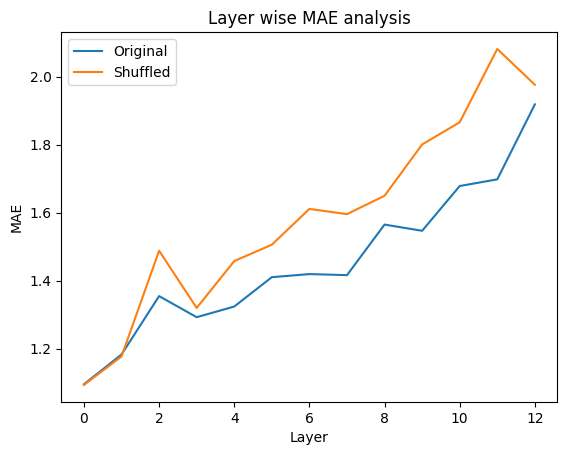

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(range(len(maes_normal)), maes_normal, label='Original')

ax.plot(range(len(maes_shuffled)), maes_shuffled, label='Shuffled')

ax.set_xlabel('Layer')
ax.set_ylabel('MAE')
ax.set_title('Layer wise MAE analysis')
ax.legend()
plt.show()

###Observations
- It is interesting to observe that MAE for both the normal case, and when we shuffle tokens of a word before passing them to the model, MAEs follow an upward trend against layers. This is to say that earlier layers better capture information about length than later ones.
- Additionally, while not too far off, the MAE tends to be higher for the case where tokens are shuffled, than the normal case. Although in either case, across layers, the percentage error is between 10% and 20%.

# Report [10]

Make a report summarizing your findings and claims

#### Refer PDF